In [1]:
import torch
import torchvision

import cv2 as cv
import numpy as np

import foolbox as fb


In [2]:
torch.cuda.is_available()

True

In [3]:
# torchvision.models

In [4]:
model = torchvision.models.resnet152(pretrained=True)

In [5]:
model = model.eval()

In [6]:
# PyTorch ResNet18
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)


In [7]:
fmodel = fmodel.transform_bounds((0, 1))

In [8]:
assert fmodel.bounds == (0, 1)

In [9]:
# ------------np.ndarray转为torch.Tensor------------------------------------
# numpy image: H x W x C
# torch image: C x H x W
# np.transpose( xxx,  (2, 0, 1))   # 将 H x W x C 转化为 C x H x W
# tensor_skimage = torch.from_numpy(np.transpose(img_skimage, (2, 0, 1)))
# tensor_cv = torch.from_numpy(np.transpose(img_cv, (2, 0, 1)))
# tensor_pil = torch.from_numpy(np.transpose(img_pil_1, (2, 0, 1)))

In [10]:

images = np.array([np.transpose(cv.imread("../data/images/aaa4f3f9d6d61aa9.png"), (2,0,1))])
images = images/255
images = torch.from_numpy(images).type(torch.FloatTensor).cuda()
fb.plot.images(images, ncols=1, nrows=1, figsize=(10, 10))


In [11]:
images

tensor([[[[0.4275, 0.4353, 0.3961,  ..., 0.3373, 0.4627, 0.4980],
          [0.4235, 0.4392, 0.4549,  ..., 0.3529, 0.4314, 0.4745],
          [0.4275, 0.4510, 0.4431,  ..., 0.3333, 0.4314, 0.4745],
          ...,
          [0.3529, 0.3647, 0.3882,  ..., 0.1608, 0.1451, 0.1412],
          [0.3255, 0.3333, 0.3922,  ..., 0.1255, 0.1255, 0.1373],
          [0.3451, 0.3216, 0.3373,  ..., 0.1176, 0.1255, 0.1294]],

         [[0.5373, 0.5490, 0.5176,  ..., 0.4078, 0.5451, 0.6118],
          [0.5412, 0.5608, 0.5725,  ..., 0.4235, 0.5098, 0.5804],
          [0.5686, 0.5843, 0.5608,  ..., 0.4196, 0.5216, 0.5765],
          ...,
          [0.4000, 0.4000, 0.4157,  ..., 0.2118, 0.2039, 0.2039],
          [0.3804, 0.3765, 0.4235,  ..., 0.1961, 0.2000, 0.2078],
          [0.4039, 0.3686, 0.3725,  ..., 0.1961, 0.2078, 0.2039]],

         [[0.6706, 0.6667, 0.6196,  ..., 0.4863, 0.6314, 0.6941],
          [0.6471, 0.6549, 0.6667,  ..., 0.5020, 0.6000, 0.6627],
          [0.6392, 0.6588, 0.6392,  ..., 0

In [12]:
labels = torch.from_numpy(np.array([442-1])).cuda()


In [13]:
labels

tensor([441], device='cuda:0')

In [14]:
target_classes = torch.from_numpy(np.array([583-1])).cuda()

In [15]:
criterion = fb.criteria.TargetedMisclassification(target_classes)
criterion

TargetedMisclassification(PyTorchTensor(tensor([582], device='cuda:0')))

In [16]:
type(images), images.shape

(torch.Tensor, torch.Size([1, 3, 299, 299]))

In [17]:
type(labels), labels.shape

(torch.Tensor, torch.Size([1]))

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# model(images), model(images).shape

In [20]:
fmodel

In [21]:
attack = fb.attacks.L2CarliniWagnerAttack(steps=100)

In [22]:
epsilons = None

In [23]:
%time advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

CPU times: user 55.2 s, sys: 9.24 s, total: 1min 4s
Wall time: 1min 6s


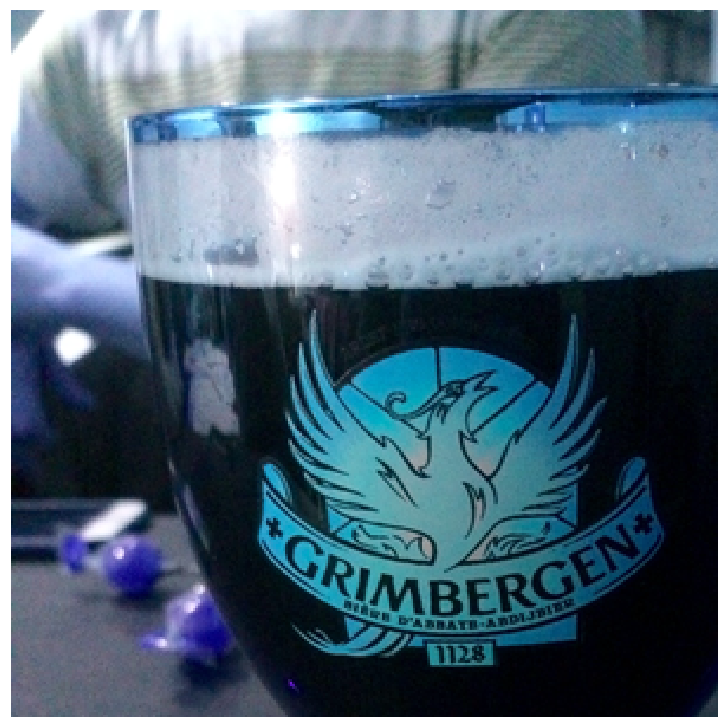

In [24]:
fb.plot.images(images, ncols=1, nrows=1, figsize=(10, 10))

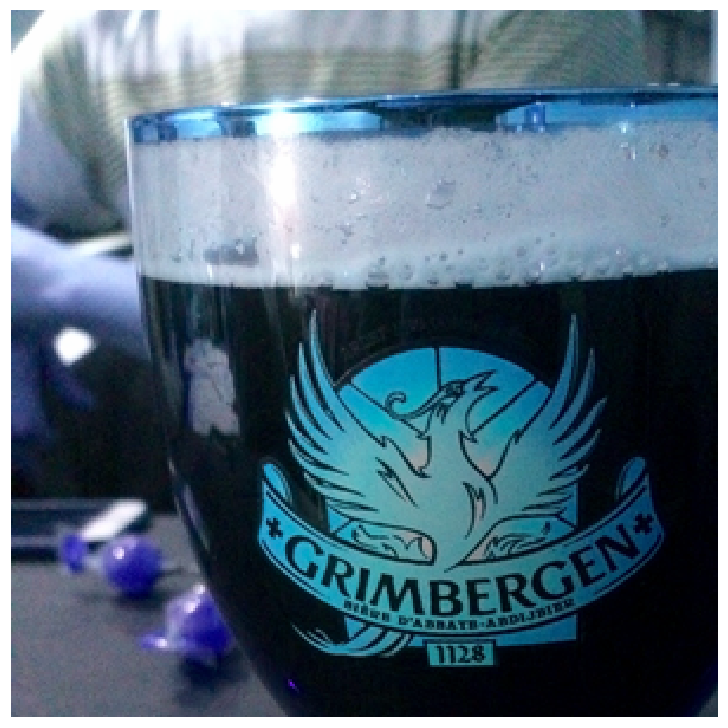

In [25]:
fb.plot.images(advs, ncols=1, nrows=1, figsize=(10, 10))

In [26]:
fb.utils.accuracy(fmodel, images, labels)

1.0

In [27]:
fb.utils.accuracy(fmodel, advs, labels)

0.0

In [28]:
fb.utils.accuracy(fmodel, advs, torch.from_numpy(np.array([583-1])).cuda())

1.0

In [29]:

_ = np.transpose(advs[0].cpu().numpy(), (1,2,0))
_ = (_ * 255)
cv.imwrite("../outs/aaa4f3f9d6d61aa9.png", _)


True

In [30]:
img0 = cv.imread("../data/images/aaa4f3f9d6d61aa9.png")
img1 = cv.imread("../outs/aaa4f3f9d6d61aa9.png")

cv.imwrite("../outs/aaa4f3f9d6d61aa9_d1.png", img0-img1)
cv.imwrite("../outs/aaa4f3f9d6d61aa9_d2.png", img1-img0)
cv.imwrite("../outs/aaa4f3f9d6d61aa9_d3.png", img0*0.50+(img0-img1)*0.50)


True

In [31]:
from IPython.display import Image

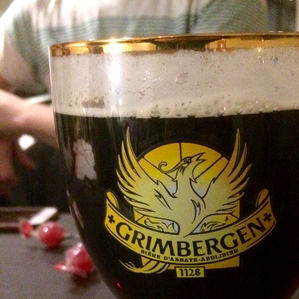

In [32]:
Image("../outs/aaa4f3f9d6d61aa9.png")

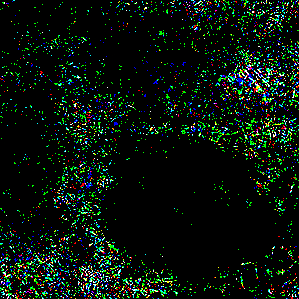

In [33]:
Image("../outs/aaa4f3f9d6d61aa9_d1.png")

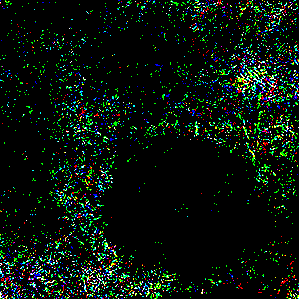

In [34]:
Image("../outs/aaa4f3f9d6d61aa9_d2.png")

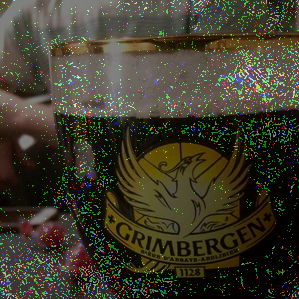

In [35]:
Image("../outs/aaa4f3f9d6d61aa9_d3.png")

In [36]:
# aaa4f3f9d6d61aa9.png,442,583